In [2]:
# import dependencies
import xarray as xr
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import hydromt
from hydromt_sfincs import SfincsModel

In [3]:
sfincs_root = "semarang_sfincs_150"  # (relative) path to sfincs root
mod = SfincsModel(sfincs_root, mode="r", deltares_data = True)

Overwriting data source dtu10mdt_egm96.
Overwriting data source gcn250.
Overwriting data source gebco.
Overwriting data source merit_hydro.
Overwriting data source osm_coastlines.
Overwriting data source vito.


In [4]:
fn_ini = 'sfincs_pupdate_semarang_RP_50.ini'
with open(fn_ini, 'r') as f:
    txt = f.read()
print(txt)

[setup_config]
tref = 20210130 000000
tstart = 20210130 000000
tstop = 20210215 000000
alpha = 0.5
zsini = 0.5

[setup_gauges]
gauges_fn = data/gauges_locations_semarang_pluvial.csv # geometry location
crs = 4326

[setup_p_forcing_from_grid]
precip_fn = era5_hourly         # gridded precipitation data ['precip']
dst_res = None                  # output resolution (m)
aggregate = True                # if True return the aggregated mean as spatially uniform precip


In [4]:
!hydromt update sfincs ./semarang_sfincs_150 -o ./semarang_sfincs_pluvial_RP_50 -i sfincs_pupdate_semarang_RP_50.ini -vv --dd

2022-06-08 16:01:56,477 - update - log - DEBUG - Appending log messages to file C:\Users\ampolini\Workingfolder\hydromt_sfincs-main\examples\semarang_sfincs_pluvial_RP_50\hydromt.log.
2022-06-08 16:01:56,477 - update - log - INFO - HydroMT version: 0.4.5
2022-06-08 16:01:56,477 - update - main - INFO - Updating sfincs model at C:\Users\ampolini\Workingfolder\hydromt_sfincs-main\examples\semarang_sfincs_150 (r).
2022-06-08 16:01:56,477 - update - main - INFO - Output dir: C:\Users\ampolini\Workingfolder\hydromt_sfincs-main\examples\semarang_sfincs_pluvial_RP_50
2022-06-08 16:01:56,477 - update - main - INFO - User settings:
2022-06-08 16:01:56,488 - update - model_plugins - DEBUG - Loaded model plugin 'sfincs = hydromt_sfincs.sfincs.SfincsModel' (0.2.1)
2022-06-08 16:01:56,489 - update - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v0.2.1).
2022-06-08 16:01:56,489 - update - data_adapter - INFO - Adding deltares_data v0.0.6 sources from https://github.com/DirkEiland

In [5]:
sfincs_root = "semarang_sfincs_pluvial_RP_50"  # (relative) path to sfincs root
mod = SfincsModel(sfincs_root, mode="r", deltares_data= True)

Overwriting data source dtu10mdt_egm96.
Overwriting data source era5_hourly.
Overwriting data source gcn250.
Overwriting data source gebco.
Overwriting data source merit_hydro.
Overwriting data source osm_coastlines.
Overwriting data source vito.


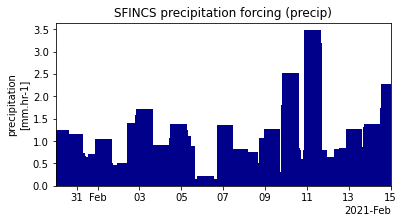

In [6]:
%matplotlib inline
from hydromt_sfincs import SfincsModel
import matplotlib.pyplot as plt
mod = SfincsModel(root="semarang_sfincs_pluvial_RP_50", mode="r")
mod.forcing.pop('bzs', None)  # let's focus on precip for now
_ = mod.plot_forcing()

In [10]:
sfincs_root = "semarang_sfincs_pluvial_RP_50"  # (relative) path to sfincs root
mod = SfincsModel(sfincs_root, mode="r", deltares_data= True)
hmax = mod.results['hmax']
hmax = hmax.reindex(y=list(reversed(hmax['y'].values))) # change orientation to N -> S
hmax.raster.to_raster(join(mod.root, 'gis', 'hmax.tif'), compress='LZW')

Overwriting data source dtu10mdt_egm96.
Overwriting data source era5_hourly.
Overwriting data source gcn250.
Overwriting data source gebco.
Overwriting data source merit_hydro.
Overwriting data source osm_coastlines.
Overwriting data source vito.


In [11]:

print(mod.data_catalog["gswo"])
gswo = mod.data_catalog.get_rasterdataset("gswo", buffer=10)
# permanent water where water occurence > 5%
gswo_mask = gswo.raster.reproject_like(mod.staticmaps, method="max") <= 5

{'category': 'hydrography',
 'data_type': 'RasterDataset',
 'driver': 'raster',
 'paper_doi': '10.1038/nature20584',
 'paper_ref': 'Pekel et al. (2016)',
 'path': 'p:\\wflow_global\\hydromt\\hydrography\\gswo\\occur.vrt',
 'source_url': 'https://global-surface-water.appspot.com/download',
 'source_version': 'v1_1_2019'}


nodata value missing for p:\wflow_global\hydromt\hydrography\gswo\occur.vrt


In [12]:
hmin = 0.25  # minimum flood depth [m] to plot
da_hmax = mod.results["hmax"]  # hmax is computed from zsmax - zb
# get overland flood depth with GSWO and set minimum flood depth
da_hmax_fld = da_hmax.where(gswo_mask).where(da_hmax > hmin)
# update attributes for colorbar label later
da_hmax.attrs.update(long_name="flood depth", unit="m")

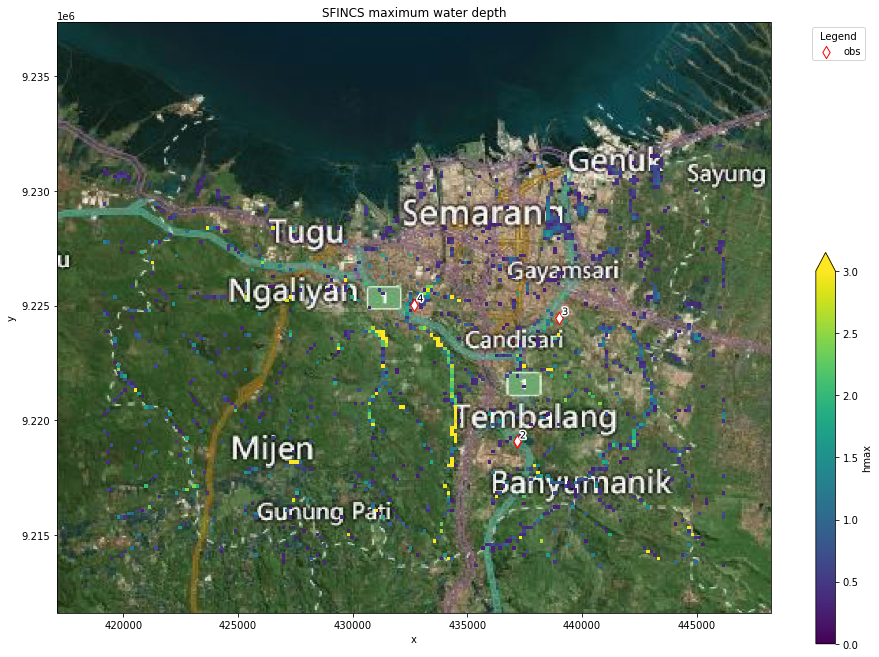

In [13]:
# create hmax plot and save to mod.root/figs/hmax.png
fig, ax = mod.plot_basemap(
    fn_out=None,
    variable=None,
    bmap="sat",
    geoms=["src", "obs"],
    plot_bounds=False,
    figsize=(16, 12),
)
# plot overland flooding based on gswo mask and mimum flood depth
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}
cax_fld = da_hmax_fld.plot(
    ax=ax, vmin=0, vmax=3.0, cmap=plt.cm.viridis, cbar_kwargs=cbar_kwargs
)

ax.set_title(f"SFINCS maximum water depth")
plt.savefig(join(mod.root, 'figs', 'hmax.png'), dpi=225, bbox_inches="tight")